We want to test if dispersion has a noticeable effect on the resulting beta output.

We will create a grid of dispersion values to test, including a previous value (0.04) that was our MLE in MCMC testing.

Then, we will analyze the resulting beta outputs from each particle filter run.

In [1]:
import pandas as pd
import numpy as np

# Previous MLE was with a dispersion ~0.07
dispersion_grid = [0.01, 0.04, 0.07, 0.15, 0.3, 0.6]
dispersion_grid 

[0.01, 0.04, 0.07, 0.15, 0.3, 0.6]

In [2]:
from jax import Array
from jax.typing import ArrayLike
from os import path
import toml
from src.pmcmc.helpers import get_data_since_week_26, get_previous_80_rows
from src.pmcmc.location import Location
from src import paths
from src.pmcmc.initialize_filter import initialize_particle_filter
from src.pmcmc.filter_algo import ParticleFilterAlgo
from logging import getLogger


def get_hosp_observations(location_code, target_date) -> (ArrayLike, Location):
    """
    Returns an array of hospital observations.
    Time series starts on 2023-06-25 and ends on target_date.
    """
    location = Location(location_code)
    target_date = pd.to_datetime(target_date)
    filtered_state_data = get_previous_80_rows(location.hosp_data, target_date)
    observations = filtered_state_data[
        "previous_day_admission_influenza_confirmed"
    ].values
    return observations, location


def pf_setup(location_code: str, target_date: str, dispersion: float) -> ParticleFilterAlgo:
    """
    Quick and dirty PF setup routine for testing.
    """
    observations, location = get_hosp_observations(location_code, target_date)

    # Determine number of days for PF to estimate, based on length of data.
    time_steps = len(observations)

    location_info = {
        "population": location.population,
        "location_code": location_code,
        "target_date": target_date,
        "runtime": time_steps,
    }

    config_path = path.join(paths.PMCMC_DIR, "config.toml")
    config = toml.load(config_path)
    logger = getLogger()

    pf_algo = initialize_particle_filter(state_population=location_info["population"],
                                         location_code=location_code,
                                         target_date=target_date,
                                         runtime=80,
                                         logger=logger,
                                         dispersion=dispersion)
    return pf_algo



Running with 150 particles.

In [8]:
import numpy as np
from tqdm.notebook import tqdm
import jax.numpy as jnp
from src.pmcmc.initialize_filter import initialize_particle_filter

all_betas = np.zeros((len(dispersion_grid), 80))
all_outputs = []

observations, location = get_hosp_observations('04', '2023-12-01')

# Loop with tqdm for progress bar
for i, dispersion_val in enumerate(tqdm(dispersion_grid, desc="Running Loops")):
    pf = pf_setup('04', target_date='2023-12-01', dispersion=dispersion_val)
    output = pf.run(observation_data=observations, theta={'dispersion': dispersion_val})
    current_betas = output.betas
    mean_over_particles = jnp.mean(current_betas, axis=0)
    mean_over_particles_numpy = jnp.array(mean_over_particles)
    all_betas[i, :] = mean_over_particles_numpy
    all_outputs.append(output)


Running Loops:   0%|          | 0/6 [00:00<?, ?it/s]

Running Particle Filter:   0%|          | 0/80 [00:00<?, ?it/s]

Running Particle Filter:   0%|          | 0/80 [00:00<?, ?it/s]

Running Particle Filter:   0%|          | 0/80 [00:00<?, ?it/s]

Running Particle Filter:   0%|          | 0/80 [00:00<?, ?it/s]

Running Particle Filter:   0%|          | 0/80 [00:00<?, ?it/s]

Running Particle Filter:   0%|          | 0/80 [00:00<?, ?it/s]

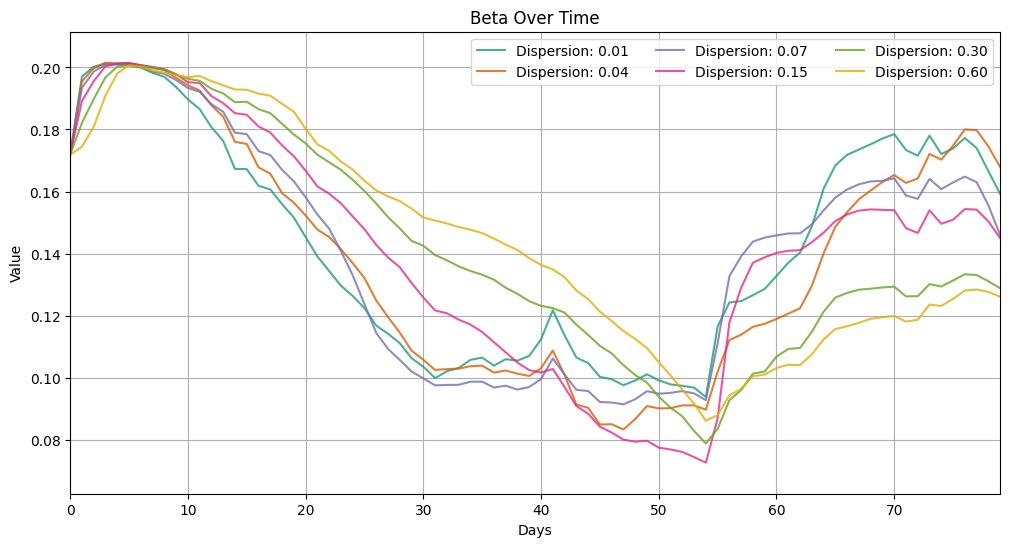

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

cmap = plt.cm.viridis
norm = plt.Normalize(vmin=min(dispersion_grid), vmax=max(dispersion_grid))
palette = sns.color_palette("Dark2", len(dispersion_grid))

data=all_betas
plt.figure(figsize=(12, 6))

# Plot each iteration in a different color
for i, (dispersion_val, color) in enumerate(zip(dispersion_grid, palette)):
    plt.plot(data[i], label=f'Dispersion: {dispersion_val:.2f}', color=color, alpha=0.8)  # Adjust alpha for transparency

# Add labels and title
plt.xlabel('Days')
plt.ylabel('Value')
plt.title('Beta Over Time')
plt.xlim(0, 79)  # Day indices from 0 to 79 (80 days)
plt.ylim(data.min() - 0.01, data.max() + 0.01)  
plt.grid()

plt.legend( fontsize='medium', ncol=3)  

plt.show()

/tmp/ipykernel_282982/4017245849.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='dispersion', y='likelihood', palette=palette)


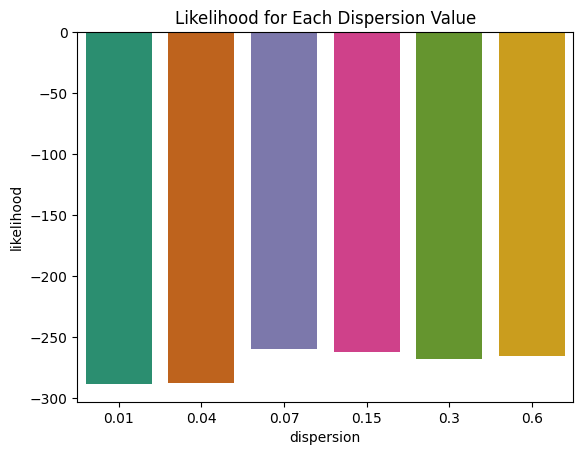

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

likelihoods = [jnp.sum(output.likelihood).item() for output in all_outputs]

df = pd.DataFrame({'dispersion': dispersion_grid, 'likelihood': likelihoods})

sns.barplot(data=df, x='dispersion', y='likelihood', palette=palette) 
plt.title('Likelihood for Each Dispersion Value')

plt.show()